# Das Vier-Quadranten-Diagramm

In [ ]:
#Imports

import cv2
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
# Open diagram
# Original Source = https://de.wikipedia.org/wiki/Verbrauchskennfeld#/media/File:Brake_specific_fuel_consumption.svg
bgra = cv2.imread(r'Muscheldiagramm.png', cv2.IMREAD_UNCHANGED)

sel = bgra[:,:,3]<255

bgra[sel]=[255,255,255,0] #Remove Alpha and replace with whit
bgr = bgra[:,:,0:3] #get BGR (without Alpha)
img = bgr[:,:,::-1] #convert BGR to RGB

# Define colors (used in diagram)
colors_in = np.array(((0, 0, 0), # Maximum, black
                  (0, 0, 255),
                  (0, 0, 191),
                  (0, 0, 127),
                  (0, 0, 63),
                  (0, 255, 0),
                  (0, 191, 0),
                  (0, 127, 0),
                  (0, 63, 0),
                  (255, 0, 0),
                  (191, 0, 0),
                  (127, 0, 0),
                  (63, 0, 0),
                  (63, 63, 63),
                  (127, 127, 127),
                  (191, 191, 191)),
                  np.uint8)

#colors_out

color_moment = np.array((0, 0, 0))
color_good = np.array((113, 167, 2))
color_bad = np.array((167, 110, 2))

ratio = np.arange(0,1,1/(colors_in.shape[0]-1))
colors_bad = np.tile(color_bad, (colors_in.shape[0]-1,1))
colors_out = np.tile(color_good, (colors_in.shape[0],1))

colors_out[0] = color_moment
colors_out[1:] = (colors_out[1:].T*(1-ratio) + colors_bad.T*ratio).T

<IPython.core.display.Javascript object>


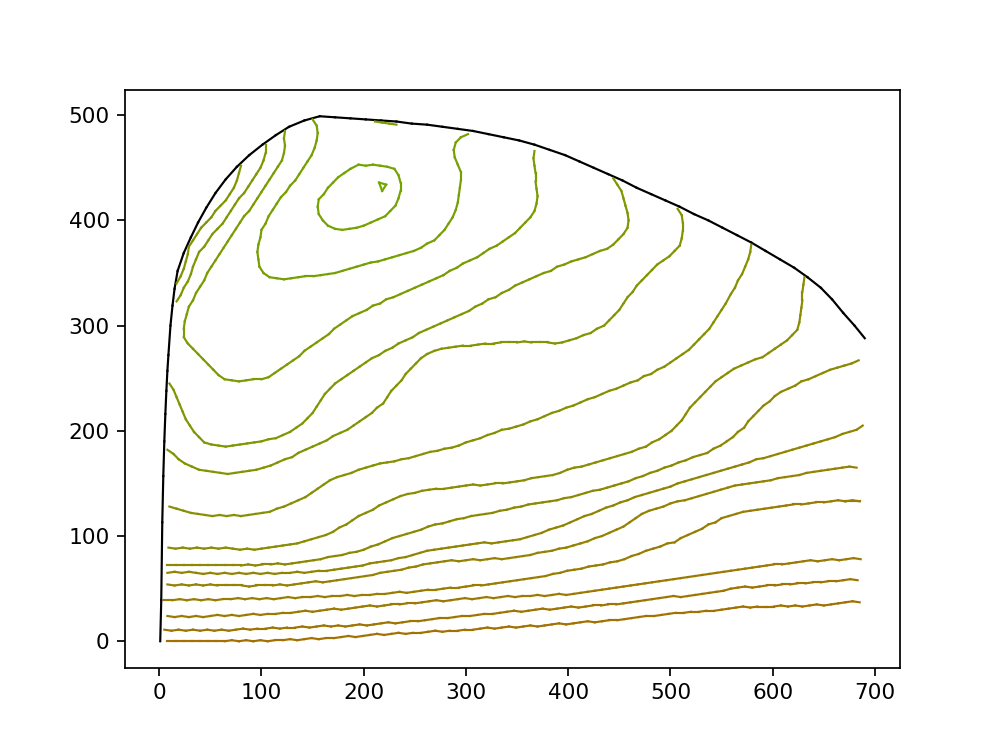

Loaded


In [3]:
def sort_points(indices):
    """Finds always the next closest point and sorts array"""
    
    ind = np.empty(shape=indices.shape, dtype=np.float)
    ind[1:,:] = np.nan
        
    for i in range(1,len(indices)-1):
        if not np.isnan(indices[i])[0]:
            row = indices[i]
            i += 1
            
            dist=np.linalg.norm(indices[i+1:,:]-row, axis=1)
            
            if dist != []:

                dist
                j = np.argmin(dist)


                found_ind = np.where(dist==dist[j])[0]+i+1

                if len(found_ind)>0:
                    ind[i] = indices[found_ind[0]]
                    for f in found_ind:
                        indices[f] = np.nan
                        
    ind_ret = np.asarray(ind[~np.isnan(ind).any(axis=1)], dtype=np.int32)
    
    return ind_ret[1:,:]

# Note
# y-axis top to bottom
# x-axis left to right

def plot_lines(ax, lines, colors, linewidth=1):
    line_objs = []
    for i, l in enumerate(lines):
        for ele in l:
            obj, = ax.plot((ele[0], ele[1]),(ele[2], ele[3]), color=colors[i]/255, linewidth=linewidth)
            line_objs.append(obj)
            
    return line_objs
    

def get_color(img, col):
    dist = (abs(img[:,:].astype(dtype=float)-col) <= 5)
    bol_close = dist.all(axis=2)
    indices = np.asarray(np.where(bol_close), dtype=float).transpose()
    return indices

def find_upper_boundary_M(img):
    
    indices = get_color(img, colors_in[0])
    
    maxM = np.empty(shape=img.shape[1], dtype=np.float)
    
    for px in range(img.shape[1]): # find max y-position for each column of image
        ypxs = np.where(indices[:,1]==px)
        ylim = int(indices[ypxs, 0].max())
        maxM[px] = img.shape[0]-1-ylim
        img[:ylim,px,:] = (255, 255, 255)
        
        
    return maxM
    
def find_contour(indices,rmax=20, rmin=7):
    
    yoffset = img.shape[0]-1
    lines = []
    def find_closest(pos=None, pprev=None):
        
        if pos is None:
            found = np.where(indices[:,0]>0)[0][0]
            pos = found
        
        p = indices[pos,:].copy()
        indices[pos,:] = -200
        
        # Remove closest
        dist = np.linalg.norm(indices - p, axis=1)
        indices[dist<= rmin,:] = -200
        
        # Check if close by still points
        dist = np.linalg.norm(indices - p, axis=1)
        dmin = dist.min()
        if dmin <= rmax:
            pos = np.where(dist==dmin)[0][0]
            pnext = indices[pos,:].copy()
            add_line(p, pnext)
            plast = find_closest(pos=pos, pprev=p.copy())
            
            if (pprev is None) & (np.linalg.norm(plast-p) < rmax):
                add_line(p, plast)
                
        else:
            plast = p
            
        # Check if close by still points
        dist = np.linalg.norm(indices - p, axis=1)
        dmin = dist.min()
        if dmin <= rmax:
            pos = np.where(dist==dmin)[0][0]
            pnext = indices[pos,:].copy()
            d = np.linalg.norm(pnext - p)
            
            if (d < rmax) & (pprev is None or d < np.linalg.norm(pnext-pprev)):

                add_line(p, pnext)
                plast = find_closest(pos=pos)
            
        return plast.copy()
    
    def add_line(pstart, pend):
        lines.append(np.array((pstart[1], pend[1], yoffset-pstart[0], yoffset-pend[0])))
    
    def check_if_finished():
        return (indices[:,0]>=0).any()
    
    while check_if_finished():
        find_closest()
        
    return lines

def find_all_contours():
    indices_rawx = get_color(img, colors_in[0])
    lines = [find_contour(indices_rawx.copy(), rmax=150, rmin=15)]

    for col in colors_in[1:]:

        indices = get_color(img, col)
        lines.append(find_contour(indices))
        
    return lines


maxM_unscaled = find_upper_boundary_M(img)

lines_unscaled = find_all_contours()

fig = plt.figure()
ax = fig.add_subplot(111)
plot_lines(ax, lines_unscaled, colors_out)

print('Loaded')

In [4]:
# Offset x direction = 1000+425.2/2
# End x direction =6829/2
# deltax = 6829/2-425.2/2

lines = copy.deepcopy(lines_unscaled) #necessary, ---.copy() still has same lists handles stored

def rescale_diagramm(lines):
    # x-Offset/Delta
    xoffset = 1000+425.2/2
    deltax = 6829/2-425.2/2
    scalex = deltax/img.shape[1]
    
    def adj_x(vec):
        return (xoffset + vec*scalex)/60*2*math.pi #Scale and convert rpm to rad/s
    
    # Calculate y-Scale
    P = 70000 #70kW
    omega = adj_x(np.arange(img.shape[1]))
    scaley = P/(omega*maxM_unscaled).max()
    
    # Scale x and y
    for i, l in enumerate(lines):
        for j, ele in enumerate(l):
            lines[i][j][:2] = adj_x(ele[:2])
            lines[i][j][2:] = scaley*ele[2:]

rescale_diagramm(lines)

<IPython.core.display.Javascript object>


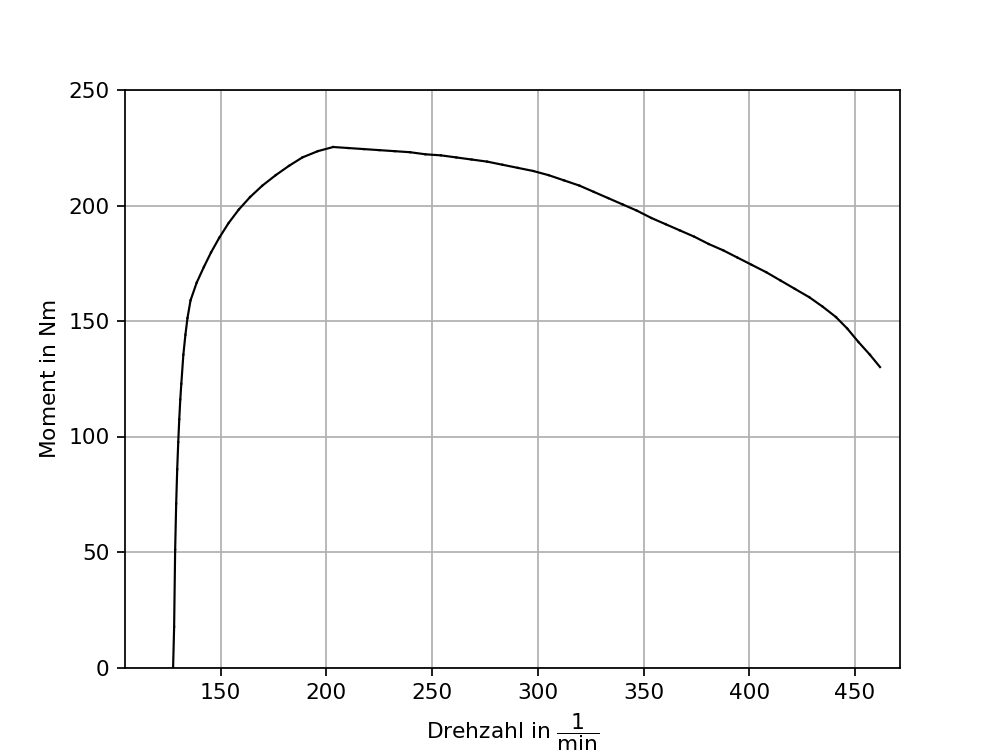

interactive(children=(Checkbox(value=False, description='Muscheldiagramm'), Output()), _dom_classes=('widget-i…

interactive(children=(Checkbox(value=False, description='Leistung'), Output()), _dom_classes=('widget-interact…

<function __main__.toggle_power(Leistung, line_objs, text_objs)>

In [5]:
fig_diagram = plt.figure()
ax_diagram = fig_diagram.add_subplot(111)
plot_lines(ax_diagram, lines[0:1], colors_out)
line_objs_diagram = plot_lines(ax_diagram, lines[1:], colors_out[1:], linewidth=0.7)

line_objs_power = []
text_objs_power = []
xpoints = np.arange(50, 5500, 50)*2*math.pi/60

for p in [10000, 30000, 50000, 70000, 90000]:
    obj, = plt.plot(xpoints, p/xpoints, color = 'grey', linewidth=0.5, linestyle='None')
    line_objs_power.append(obj)
    obj = plt.text(4500/60*2*math.pi+5, p/(4500/60*2*math.pi), str(int(p/1000)) + ' kW', visible=False, horizontalalignment='left')
    text_objs_power.append(obj)
    
res, = plt.plot(1,1)

plt.xlabel('Drehzahl in $\dfrac{1}{\mathrm{min}}$')
plt.ylabel('Moment in $\mathrm{Nm}$')
plt.xlim(1000/60*2*math.pi, 4500/60*2*math.pi)
plt.ylim(0, 250)
plt.grid(True)

def toggle_visibility(Muscheldiagramm, line_objs, text_objs = []):
    if Muscheldiagramm:
        for line in line_objs:
            line.set_linestyle('-')
        for text in text_objs:
            text.set_visible(True)
    else:
        for line in line_objs:
            line.set_linestyle('None')
        for text in text_objs:
            text.set_visible(False)
    fig_diagram.canvas.draw()
    
def toggle_diagram(Muscheldiagramm, line_objs):
    toggle_visibility(Muscheldiagramm, line_objs)
def toggle_power(Leistung, line_objs, text_objs):
    toggle_visibility(Leistung, line_objs, text_objs)

widgets.interact(toggle_diagram, Muscheldiagramm=False, line_objs=widgets.fixed(line_objs_diagram))
widgets.interact(toggle_power, Leistung=False, line_objs=widgets.fixed(line_objs_power), text_objs=widgets.fixed(text_objs_power))

## Widerstände berechnen

Radwiderstand:

$F_\mathrm{W,R}=f_\mathrm{r} \cdot m \cdot g$

Steigungswiderstand:

$F_\mathrm{W,St} = \sin(\alpha) \cdot m \cdot g \approx \alpha \cdot m \cdot g$

Luftwiderstand:

$F_\mathrm{W,L}=\dfrac{1}{2}c_\mathrm{w} \cdot A \cdot \rho_{\mathrm{L}} \cdot v_\mathrm{rel}^2$

Beschleunigungswiderstand:

$F_\mathrm{W,Be}= m \cdot a$

<IPython.core.display.Javascript object>


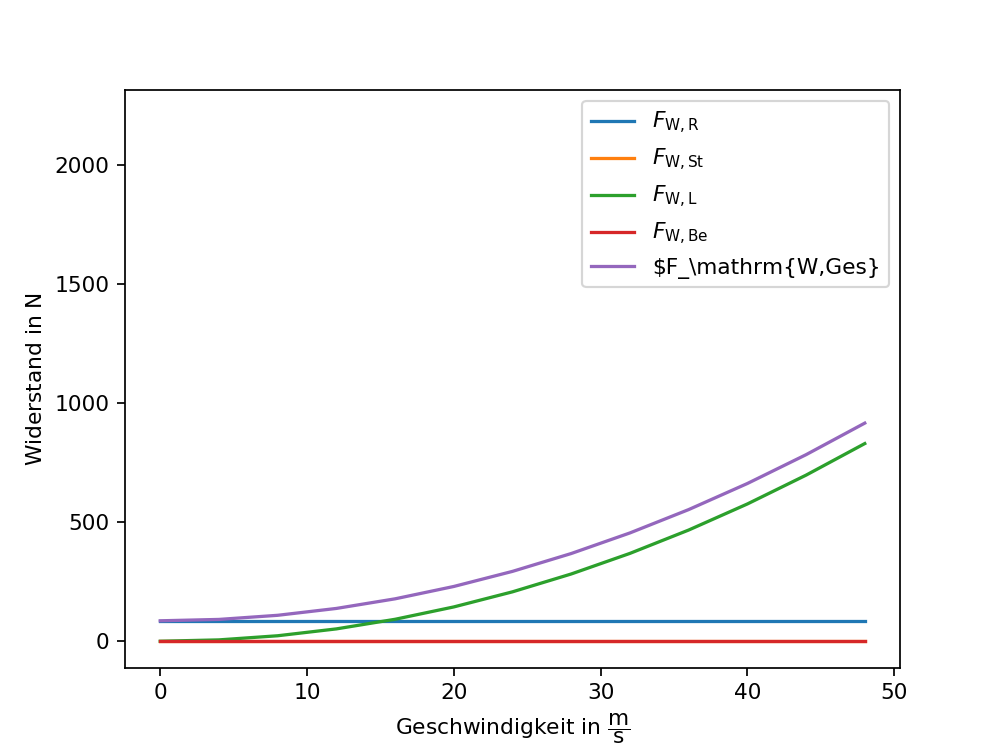

interactive(children=(FloatSlider(value=0.007, description='fr', max=0.015, step=0.001), IntSlider(value=1250,…

<function __main__.F(fr, m, cwA, vwind, a, alpha)>

In [6]:
g = 9.81
rhol = 1.2
cwA = 0.7

def FWR(fr,m):
    return np.ones(shape=v.shape)*fr*m*g

def FWS(alpha, m):
    return np.ones(shape=v.shape)*alpha*m*g

def FWL(cwA, vwind):
    vrel = (v-vwind)
    return 1/2*rhol*cwA*vrel*vrel*np.sign(vrel)

def FWA(a, m):
    return np.ones(shape=v.shape)*a*m

fig_res = plt.figure()
fig_res.add_subplot(111)

v = np.arange(0,50,4)

fwr_vals = FWR(0.1, 1400)
fws_vals = FWS(0, 1400)
fwl_vals = FWL(0.6, 0)
fwa_vals = FWA(0, 1400)
    
hFWR, = plt.plot(v, fwr_vals)
hFWS, = plt.plot(v, fws_vals)
hFWL, = plt.plot(v, fwl_vals)
hFWA, = plt.plot(v, fwa_vals)
hFT, = plt.plot(v, fwr_vals+fws_vals+fwl_vals+fwa_vals)

plt.legend(['$F_\mathrm{W,R}$', '$F_\mathrm{W,St}$', '$F_\mathrm{W,L}$', '$F_\mathrm{W,Be}$', '$F_\mathrm{W,Ges}$'])
plt.xlabel('Geschwindigkeit in $\mathrm{\dfrac{m}{s}}$')
plt.ylabel('Widerstand in $\mathrm{N}$')

def F(fr, m, cwA, vwind, a, alpha):
    fwr_vals = FWR(fr, m)
    fws_vals = FWS(alpha, m)
    fwl_vals = FWL(cwA, vwind)
    fwa_vals = FWA(a, m)
    
    hFWR.set_ydata(fwr_vals)
    hFWS.set_ydata(fws_vals)
    hFWL.set_ydata(fwl_vals)
    hFWA.set_ydata(fwa_vals)
    hFT.set_ydata(fwr_vals+fws_vals+fwl_vals+fwa_vals)

widgets.interact(F, fr=(0,.015, 0.001), m=(900, 1600, 50), cwA=(0.3, 1, 0.1), vwind=(-15, 15, 1), a=(-5, 5, 0.25), alpha=(-0.05, 0.05, 0.01))


<IPython.core.display.Javascript object>


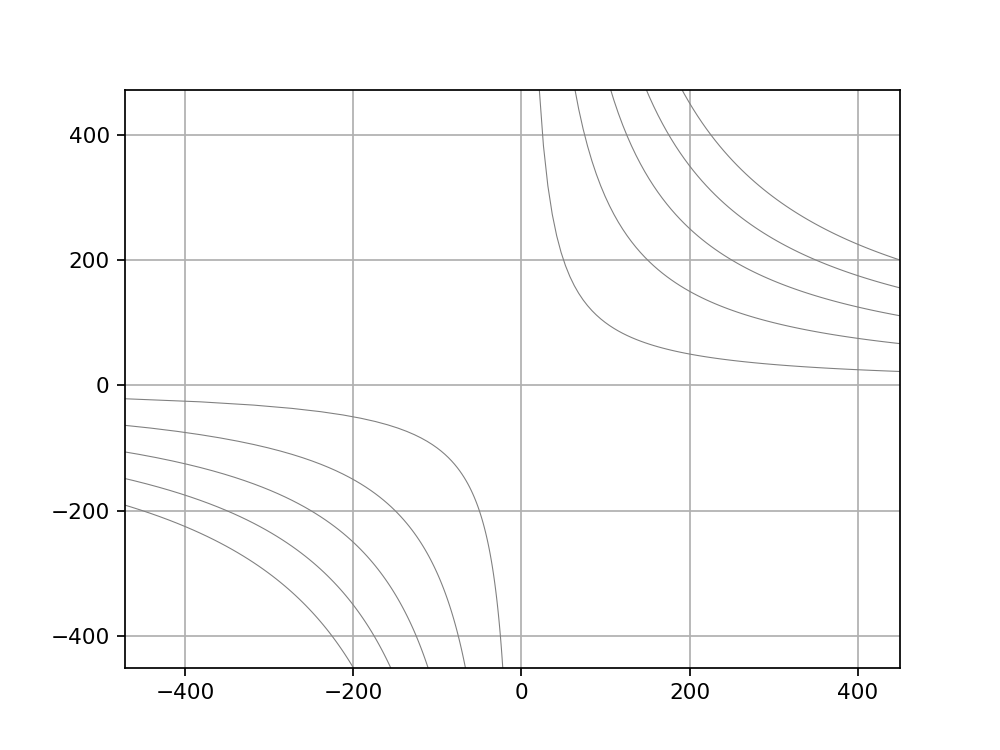

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylim(-450, 4500/60*2*math.pi)
plt.xlim(-4500/60*2*math.pi, 450)
plt.grid(True)

for p in [10000, 30000, 50000, 70000, 90000]:
    obj, = plt.plot(-p/xpoints, -xpoints, color = 'grey', linewidth=0.5, linestyle='-')
    obj, = plt.plot(xpoints, p/xpoints, color = 'grey', linewidth=0.5, linestyle='-')